# A/B Testing in PyMC: part 1

<div class="alert alert-warning">
<h2>Goal of this session:</h2>

In this hands-on session, you will continue working with the synthetic dataset from yesterday. Your goal is to be able to perform Bayesian inference using the PyMC library. The insight gained from this session will help you understand:

- How to perform Bayesian A/B testing on data with Bernoulli conversions
- How to interpret the results
- How to use ArviZ library to visualize the results

</div>


Let's practice what you have learned this morning. You will be using the [PyMC library](https://www.pymc.io/welcome.html) to do Bayesian inference and explore posterior distributions. 

You only workout the case of two variants A and B with **Bernoulli conversions** using the data from yesterday. Let's start by importing the necessary libraries.

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm

## Your First Try

Remember the example with synthetic data where we had a website with two variants A and B. Let's assume that we have a Bernoulli likelihood for each variant, and we can model the conversion rate as Beta distribution for each variant. To start with, let's assume that we have identical priors for both variants with $\alpha = 1$ and $\beta = 1$:

In [2]:
# let's define the variants A and B
variants  = ['A', 'B']

# let's define parameters for a weak prior for the conversion rates
prior_alpha, prior_beta = [1, 1]

Now, replace the `< >` with the values observed from the data:

In [3]:
# number of visitors for each variant 
visitors   = [1000, 1000]

# number of conversions (sign ups) for each variant
conversion = [502, 510]

The model, defined in the next cell, consist of four main components:
- Prior
- Likelihood
- Uplift (difference between A and B)
- Posterior

Let's run the code

In [4]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = prior_alpha, 
                    beta  = prior_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n        = visitors, 
                      observed = conversion, 
                      p        = theta,
                      shape    = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Note that in the last line we set `return_inferencedata=False` and you can set to True later on.

Run each of the following cells and try to understand their output.

In [5]:
# Check the unobserved random variables:
example_model.unobserved_RVs    

[theta ~ Beta(1, 1), uplift ~ Deterministic(f(theta))]

In [6]:
# Check the observed (synthetic) random variable:
example_model.observed_RVs    

[y ~ Binomial(<constant>, theta)]

In [7]:
# Check the deterministic random variable:
example_model.deterministics

[uplift ~ Deterministic(f(theta))]

In [8]:
# check the trace, i.e. posterior distribution of the conversion rates
trace

<MultiTrace: 4 chains, 1000 iterations, 3 variables>

In [9]:
# find out the shape of the trace
trace.theta.shape,  trace.uplift.shape 

((4000, 2), (4000,))

<div class="alert alert-info">
<h4>Task 1</h4>

1. What do you learn from the `shapes` of the converation rates and the uplift?

2. Why do you have 4000 samples despite setting `draws=1000`?

</div>

**Answer:**

1. $\theta_A$ and $\theta_B$ represent the posterior distributions of the conversion rates for variant A and B respectively. The uplift represents the posterior distribution of the difference between $\theta_A$ and $\theta_B$. The shapes of the converation rates is (4000, 2) meaning that we have 4000 samples for $\theta_A$ and $\theta_B$ respectively. The shape of the uplift is (4000,) meaning that we have 4000 samples for the difference between $\theta_A$ and $\theta_B$.

2. We have 4000 samples because we have 4 chains and 1000 samples per chain. 

Let's continue by exploring the posterior distributions of the conversion rates and the uplift.

In [10]:
# let's create a dataframe with the output of the posterior distribution
df = pd.concat([pd.DataFrame(trace['theta']), 
                pd.DataFrame(trace['uplift'])],
                axis=1)

df.columns = ['theta_A','theta_B','uplift']
df.head(3)

,theta_A,theta_B,uplift
0,0.497876,0.515906,0.036215
1,0.488730,0.492827,0.008384
2,0.524078,0.503585,-0.039102


<div class="alert alert-info">
<h4>Task 2</h4>

1. What are the average conversion rates according to the posterior distributions? Are they inline with your expectations? 

2. Are the averages closer to the conversion rates observed from data or the priors? 

3. What is the average uplift. Discuss what you observe.

</div>

**Answer:**

1. The averages of the conversion rates are near 0.50 for variant A and B (see table below). Yes, these values are inline with our expectations.

2. The averages are close to what we observed from data, but not as close to the priors. In fact, priors aren't informative in this case, and all we get in the posterior is from the data.

3. The average uplift is posittive and slightly greater than 0. This means that variant B is slightly better than variant A. That is inline with what we observed from data.

In [11]:
df.describe()

,theta_A,theta_B,uplift
count,4000.000000,4000.000000,4000.000000
mean,0.501846,0.509961,0.017189
std,0.015807,0.015872,0.045349
min,0.441810,0.456081,-0.142912
25%,0.491467,0.499682,-0.012828
50%,0.501646,0.510257,0.015833
75%,0.512343,0.520291,0.045855
max,0.560784,0.563000,0.199950


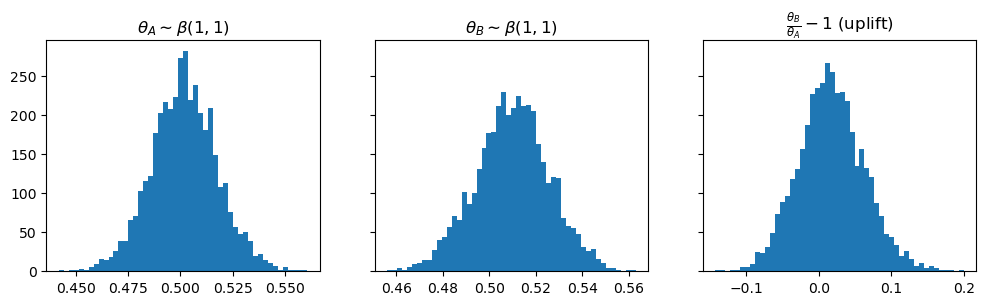

In [12]:
# let's create a subplot that shows the theta_A, theta_B and uplift
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# plot the distribution of theta_A
ax[0].hist(df['theta_A'],bins=50,)
ax[0].set_title(r'$\theta_A \sim \beta (1,1)$')

# plot the distribution of theta_B
ax[1].hist(df['theta_B'],bins=50,)
ax[1].set_title(r'$\theta_B \sim \beta (1,1)$')

# plot the distribution of uplift
ax[2].hist(df['uplift'], bins=50,)
ax[2].set_title(r'$\frac{\theta_B}{\theta_A} - 1$ (uplift)')

plt.show()

## PyMC Visualisation Options

Let's redo the previous example but this time we set the `return_inferencedata` to True. This will return an `InferenceData` object which we can use to visualise the posterior distributions. The `InferenceData` object contains the posterior samples and many other details about the model.

In [13]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = prior_alpha, 
                    beta  = prior_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n        = visitors, 
                      observed = conversion, 
                      p        = theta,
                      shape    = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [14]:
# let's check the trace
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<div class="alert alert-info">
<h4>Task 3</h4>

In the above result, click on the **posterior** tab:

1. What do you see under the **Data variables** section?

2. Click on the database icon at the right-end of the **theta** row. What do you see?

3. What do you see under the **Dimensions** section?

</div>

**Answer:**

1. The theta and uplift posterior variables are stored under the posterior.

2. The values are accessible in an array.

3. The dimensions show that there are 4 chains, each with 1000 draws, for both $\theta_A$ and $\theta_B$.

We can also use the ArviZ library for plotting. The main advantage is that it works pretty well with the output data. Also, it gives the HDI for the relative Uplift distribution.

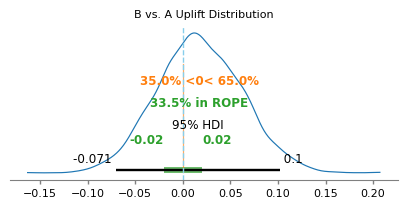

In [15]:
az.plot_posterior(trace.posterior["uplift"], figsize=(5, 2),textsize=8,
                        point_estimate=None,
                        ref_val=0,  
                        hdi_prob= 0.95, #'hide', 
                        rope=[-0.02, 0.02]
                )
plt.title("B vs. A Uplift Distribution", fontsize=8,)
plt.axvline(x=0, color='#87ceeb', linestyle='--', linewidth=1);

<div class="alert alert-info">
<h4>Task 4</h4>

1. What is your interpretation of the 95% HDI?

2. What is the probability that the uplift is greater than 0?
    
3. What do you learn from the ROPE?

4. What is your conclusion about the A/B test?

</div>

**Answer:**

1. The 95% HDI shows that there is a 95% probability that the uplift is between the lower and upper bounds of the HDI.

2. The probability that the uplift is greater than 0 is slightly greater than 0.6 (find the calculation below, or see the orange numbers in the plot). This means that there is around 60% probability that variant B is better than variant A.

3. With this specific ROPE we decide to take A and B as equivalent. We tolerate their difference being within this range. 

4. Variant B is only slighly better than variant A. Since our desired ROPE happen to be fully inside the HDI, we consider A and B as the same.

In [16]:
(trace.posterior["uplift"]>0).mean().values

array(0.65025)

There are many other plots that you can do with ArviZ. You can find more examples [here](https://arviz-devs.github.io/arviz/examples/index.html), but let's try a few of them.

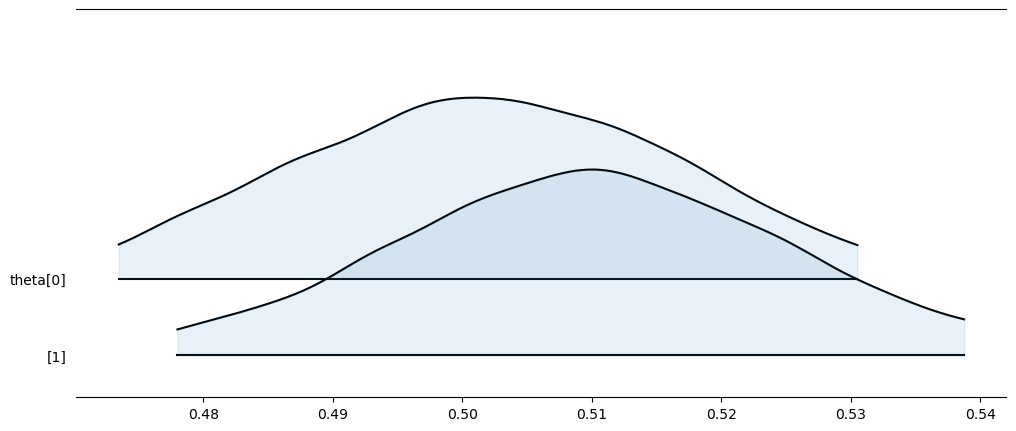

In [17]:
# what about the theta distributions?
az.plot_forest(trace, var_names=["theta"], combined=True, kind="ridgeplot", ridgeplot_alpha=0.1);

With `plot_trace` we get a full picture.

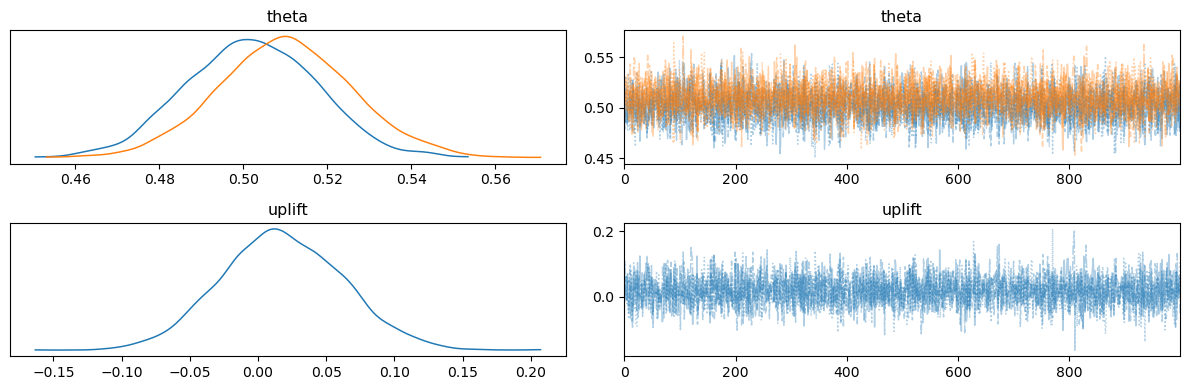

In [18]:
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

Yet another view with `plot_pair` and `plot_violin`:

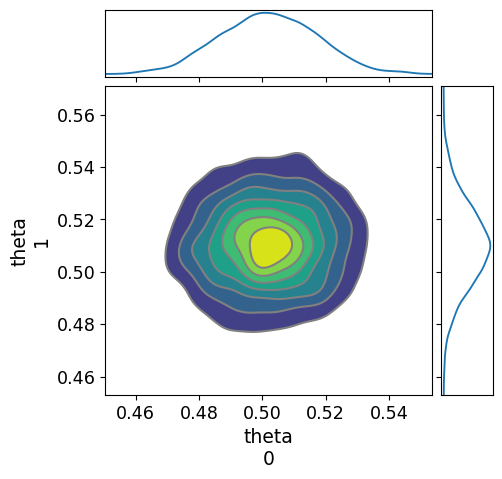

In [19]:
az.plot_pair(trace, var_names=["theta"], kind="kde", marginals=True, figsize=(5, 5));

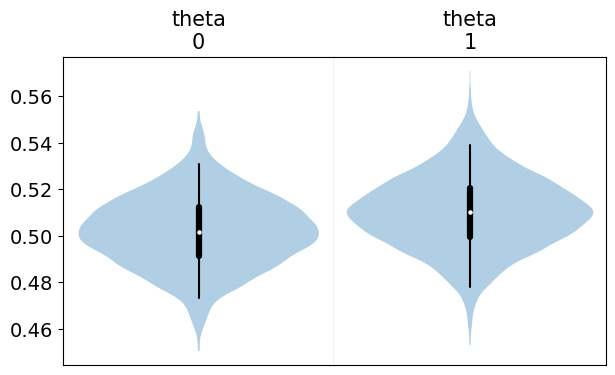

In [20]:
az.plot_violin(trace, var_names=["theta"], figsize=(7, 4));

<div class="alert alert-info">
<h4>Task 5</h4>


Try an informative prior for $\theta_A$ and $\theta_B$ especially one that is skewed, and re-do what you have done so far. How does that affect your conclusion about the difference between the two variants?

</div>

**Answer:**

The answer depends on your choice of priors. But in general, a weak prior gives **more weight to the observed data**, but could also lead to more false discoveries. A strong prior can help guard against false discoveries, but may **require more data** to detect winning variants, and more data means more time required running the test. 